# Quantifying semisc similarity
## Chapter X: Data sequence analysis patches 

### Author: Anders Kampenes

### Dimension reduction and visualization with PCA

In [2]:
### Fetched from https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoderimport numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

import numpy as np
import pandas as pd
K.clear_session()

np.random.seed(237)

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
### A. Load Data

In [4]:
import sys, os
from os.path import join, basename, dirname, exists
sys.path.insert(0, os.path.abspath('..'))
# declare parent dir name 
dirname = sys.path[0] # parent directory

train_orig = pd.read_csv(join(dirname, 'data/processed/train.csv'))
test_orig = pd.read_csv(join(dirname, 'data/processed/test.csv'))

train_orig.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
### B. Combine Train & Test

In [6]:
# create 'label' column in test dataset; rearrange so that columns are in the same order as in train
test_orig['label'] = 11
testCols = test_orig.columns.tolist()
testCols = testCols[-1:] + testCols[:-1]
test_orig = test_orig[testCols]

In [7]:
combined = pd.concat([train_orig, test_orig], ignore_index = True)

combined.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
combined.tail()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
69995,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69999,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# C. Split into training & validation sets¶


In [10]:
#Hold out 5000 random images as a validation/test sample
valid = combined.sample(n = 5000, random_state = 555)
train = combined.loc[~combined.index.isin(valid.index)]

# free up some space and delete test and combined
del train_orig, test_orig, combined

valid.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
15545,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24241,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10099,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57209,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2947,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
### 4. Reshape & normalize


In [12]:
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# labels
y_train = train['label']
y_valid = valid['label']

# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.values.reshape(-1,28,28,1)

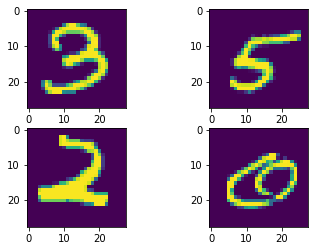

In [13]:
# We can take a look at a few random images. 
# The bottom right panel shows one of the more difficult-to-classify digits (even for humans!).
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()

In [14]:
# 3. Model construction


In [15]:
### A. Encoder network


In [69]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

In [70]:
### B. Sampling function

In [71]:
# sampling function 
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [72]:
### C. Decoder network

In [73]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [74]:
### D. Loss
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [75]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_20 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_51 (Conv2D)               (None, 28, 28, 32)    320         input_20[0][0]                   
____________________________________________________________________________________________________
conv2d_52 (Conv2D)               (None, 14, 14, 64)    18496       conv2d_51[0][0]                  
____________________________________________________________________________________________________
conv2d_53 (Conv2D)               (None, 14, 14, 64)    36928       conv2d_52[0][0]                  
___________________________________________________________________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_6" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=1,
        batch_size=batch_size,
        validation_data=(X_valid, None))

Train on 65000 samples, validate on 5000 samples
Epoch 1/1
65000/65000 [==============================] - 310s - loss: 35571.8247 - val_loss: 0.1989


In [77]:
# 5. Results


In [78]:
# Isolate original training set records in validation set
valid_noTest = valid[valid['label'] != 11]

# X's and Y's
X_valid_noTest = valid_noTest.drop('label', axis=1)
y_valid_noTest = valid_noTest['label']

# Reshape and normalize
X_valid_noTest = X_valid_noTest.astype('float32') / 255.
X_valid_noTest = X_valid_noTest.values.reshape(-1,28,28,1)

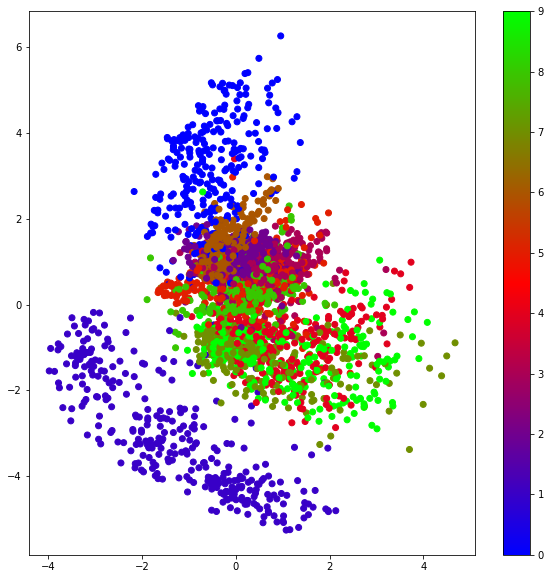

In [79]:
# Translate into the latent space  by plotting the MEAN
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(X_valid_noTest, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_valid_noTest, cmap='brg')
plt.colorbar()
plt.show()

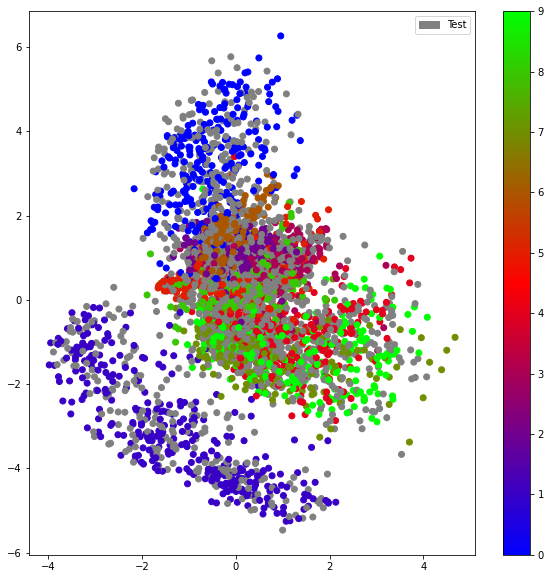

In [80]:
# set colormap so that 11's are gray
custom_cmap = matplotlib.cm.get_cmap('brg')
custom_cmap.set_over('gray')

x_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(10, 10))
gray_marker = mpatches.Circle(4,radius=0.1,color='gray', label='Test')
plt.legend(handles=[gray_marker], loc = 'best')
plt.scatter(x_valid_encoded[:, 0], x_valid_encoded[:, 1], c=y_valid, cmap=custom_cmap)
plt.clim(0, 9)
plt.colorbar()

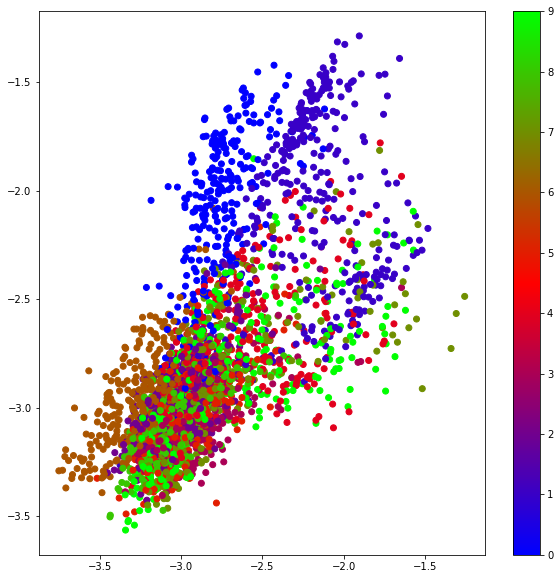

ValueError: Error when checking : expected input_20 to have 4 dimensions, but got array with shape (16472, 2)

In [85]:
# we plot the VARIANCE 
# Translate into the latent space
encoder = Model(input_img, z_log_sigma)
x_valid_noTest_encoded = encoder.predict(X_valid_noTest, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_valid_noTest, cmap='brg')
plt.colorbar()
plt.show()

X = test_x
Y = test_y
h = .09  # step size in the mesh

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = encoder.predict(np.c_[xx.ravel(), yy.ravel()], batch_size=batch_size)
#print(xx.shape, yy.shape, Z.shape)
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap="brg")
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="brg")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification")

In [27]:
#B. Sample digits


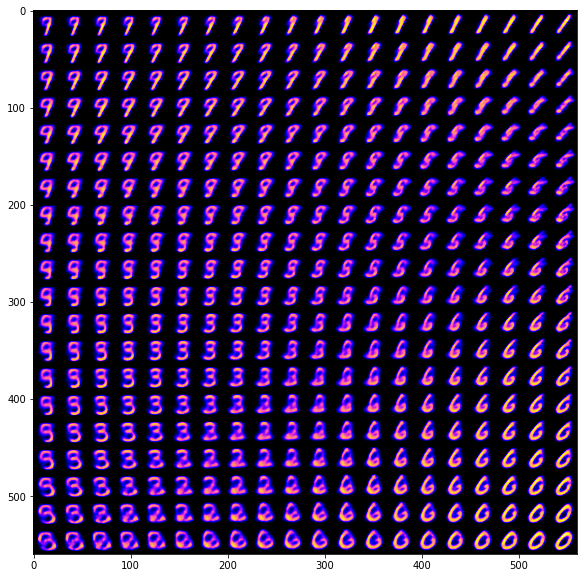

In [28]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  

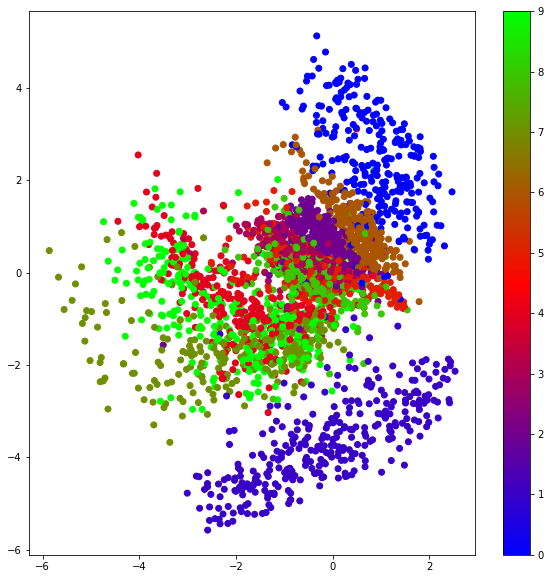

(3049, 2)
Starting kmeans...
K-MEANS:  3
K-MEANS:  1
K-MEANS:  1
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
K-MEANS:  0
Done with kmeans initiation...


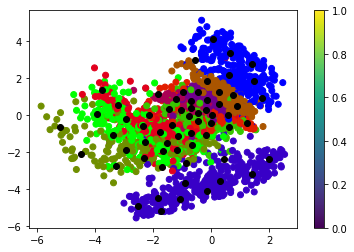


3049 10
(3049, 10)
Accuracy:  0.6782551656280748


In [29]:
# radial-basis-function-neural-network as in https://towardsdatascience.com/most-effective-way-to-implement-radial-basis-function-neural-network-for-classification-problem-33c467803319

# or better--> (sklearn and keras ) https://github.com/toxtli/RBF-Network-MNIST/blob/master/RBF_Network_MNIST.ipynb
# 1 First, we have to define the required functions that will be used in RBFNN.
# The modified “kmeans” function returns the cluster centers as well as the standard deviation of the clusters.
def get_distance(x1, x2):
    sum = 0
    for i in range(len(x1)):
        sum += (x1[i] - x2[i]) ** 2
    return np.sqrt(sum)


def kmeans(X, k, max_iters):
  
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]

    converged = False
    
    current_iter = 0

    while (not converged) and (current_iter < max_iters):

        cluster_list = [[] for i in range(len(centroids))]

        for x in X:  # Go through each data point
            distances_list = []
            for c in centroids:
                distances_list.append(get_distance(c, x))
            cluster_list[int(np.argmin(distances_list))].append(x)

        cluster_list = list((filter(None, cluster_list)))

        prev_centroids = centroids.copy()

        centroids = []

        for j in range(len(cluster_list)):
            centroids.append(np.mean(cluster_list[j], axis=0))

        pattern = np.abs(np.sum(prev_centroids) - np.sum(centroids))

        print('K-MEANS: ', int(pattern))

        converged = (pattern == 0)

        current_iter += 1

    return np.array(centroids), [np.std(x) for x in cluster_list]

# 2. To make the implementation more conducive, we can code up RBFNN as a class.
class RBF:

    def __init__(self, X, y, tX, ty, num_of_classes,
                 k, std_from_clusters=True):
        self.X = X
        self.y = y

        self.tX = tX
        self.ty = ty

        self.number_of_classes = num_of_classes
        self.k = k
        self.std_from_clusters = std_from_clusters

    def convert_to_one_hot(self, x, num_of_classes):
        print(len(x), num_of_classes)
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
            
        print(arr.shape)
        return arr

    def rbf(self, x, c, s):
        distance = get_distance(x, c)
        return 1 / np.exp(-distance / s ** 2)

    def rbf_list(self, X, centroids, std_list):
        RBF_list = []
        for x in X:
            
            RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(RBF_list)
    
# 3. Fit function: First lines performs k-means to get centroids and the standard deviation of the clusters. 
# Then we can make the algorithm to use the same Beta for all the cluster centroids by using the equation mentioned. 
# In the next lines, we get the RBF of the input X and apply Least Squares Optimization to get a proper weight matrix W.
# Additionally, to measure the accuracy of the model, test data is utilized in the last few lines.


    def fit(self):
        print("Starting kmeans...")
        self.centroids, self.std_list = kmeans(self.X, self.k, max_iters=1000)
        print("Done with kmeans initiation...")
        plt.scatter(encodings[:, 0], encodings[:, 1], c=y_valid_noTest, cmap='brg')
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1],  color='black')
        plt.colorbar()
        plt.show()

        if not self.std_from_clusters:
            dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
            self.std_list = np.repeat(dMax / np.sqrt(2 * self.k), self.k)
        
        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)
        print()
        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, self.number_of_classes)

        # test
        RBF_list_tst = self.rbf_list(self.tX, self.centroids, self.std_list)

        self.pred_ty = RBF_list_tst @ self.w

        self.pred_ty = np.array([np.argmax(x) for x in self.pred_ty])

        diff = self.pred_ty - self.ty

        print('Accuracy: ', len(np.where(diff == 0)[0]) / len(diff))
        
    def predict(self, x):
        
        RBF_list_tst = self.rbf_list(x, self.centroids, self.std_list)

        pred_y = RBF_list_tst @ self.w
        
        pred_y_class = np.array([np.argmax(x) for x in pred_y])
        pred_y_value = np.array([np.max(x) for x in pred_y])
        return pred_y_class, pred_y_value
        
    
# 4. Split MNIST data set into training and testing and let the RBFNN do its job.
# Clustering algorithms almost always use 1-dimensional data. 
# For example, if you were clustering a set of X, Y coordinates, each point would be passed to the
# clustering algorithm as a 1-dimensional array with a length of two (example: [2,4] or [-1, 4]). 
# If you were using 3-dimensional data, the array would have a length of 3 (example: [2, 4, 1] or [-1, 4, 5]).
# MNIST contains images that are 28 by 28 pixels; as a result, they will have a length of 784 once we reshape 
# them into a 1-dimensional array.

#train_y = np.asarray(y_train[:1000])
#train_x = np.asarray(X_train[:1000]).reshape(-1, 28*28)

#test_y = np.asarray(y_valid[:10])
#test_x = np.asarray(X_valid[:10]).reshape(-1, 28*28)

#print(train_x.shape)
#RBF_CLASSIFIER = RBF(train_x, train_y, test_x, test_y, num_of_classes=10, k=5, std_from_clusters=False)
#RBF_CLASSIFIER.fit()


## used on the latent space directly
encodings = encoder.predict(X_valid_noTest, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(encodings[:, 0], encodings[:, 1], c=y_valid_noTest, cmap='brg')
plt.colorbar()
plt.show()

train_y = np.asarray(y_valid_noTest)
train_x = encodings
test_y = np.asarray(y_valid_noTest)
test_x = encodings

print(train_x.shape)
RBF_CLASSIFIER = RBF(train_x, train_y, test_x, test_y, num_of_classes=10,
                     k=64, std_from_clusters=False)

RBF_CLASSIFIER.fit()



[1 1 2 ... 9 3 6] [0.71060591 1.07138644 0.6626956  ... 0.75084516 0.54378174 0.5981942 ]


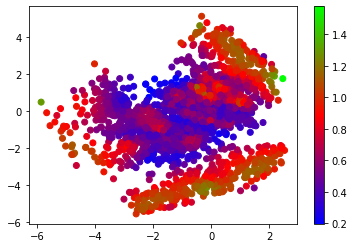

In [86]:
# test prediction 
pred_y_class, pred_y_value = RBF_CLASSIFIER.predict(test_x) # TODO HOW WO WE KNOW THAT CLUSTER 1 CORRESPONDS TO CLASS 1?
print(pred_y_class, pred_y_value)


plt.scatter(test_x[:, 0], test_x[:, 1], c=pred_y_value, cmap='brg')
plt.colorbar()
plt.show()

Text(0.5, 1.0, '3-Class classification')

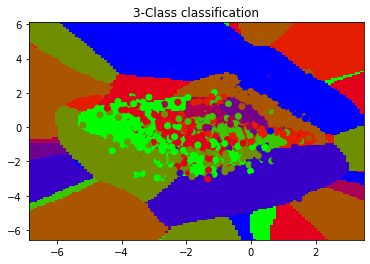

In [87]:
# Plot the decision boundary. For that, we will assign a color to each 
# point in the mesh [x_min, x_max]x[y_min, y_max].
# as in https://stackoverflow.com/questions/45075638/graph-k-nn-decision-boundaries-in-matplotlib
X = test_x
Y = test_y
h = .09  # step size in the mesh

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z, pred_y_value = RBF_CLASSIFIER.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap="brg")
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="brg")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification")

Starting kmeans...
K-MEANS:  1
K-MEANS:  0
K-MEANS:  0
Done with kmeans initiation...


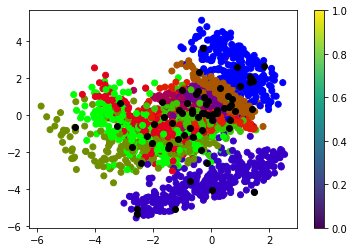


100 10
(100, 10)
Accuracy:  0.87
shappe (142, 116) (142, 116) (16472,)


Text(0.5, 1.0, '3-Class classification')

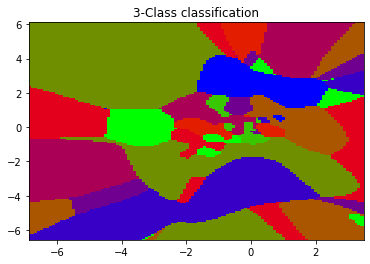

In [89]:
BAD_RBF_CLASSIFIER = RBF(train_x[:100], train_y[:100], test_x[:100], test_y[:100], num_of_classes=10,
                     k=64, std_from_clusters=False)
BAD_RBF_CLASSIFIER.fit()
# Plot the decision boundary. For that, we will assign a color to each 
# point in the mesh [x_min, x_max]x[y_min, y_max].
# as in https://stackoverflow.com/questions/45075638/graph-k-nn-decision-boundaries-in-matplotlib
X = test_x
Y = test_y
h = .09  # step size in the mesh

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z, pred_y_value = BAD_RBF_CLASSIFIER.predict(np.c_[xx.ravel(), yy.ravel()])
print("shappe",xx.shape, yy.shape, Z.shape)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap="brg")
# Plot also the training points
#plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="brg")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification")

In [1]:
encodings = encoder.predict(X_valid_noTest, batch_size=batch_size)


NameError: name 'encoder' is not defined

In [ ]:
# Interpolation ala https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df

(10, 28, 28, 1)


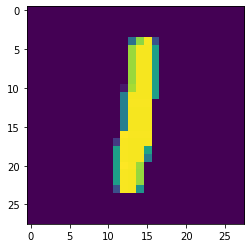

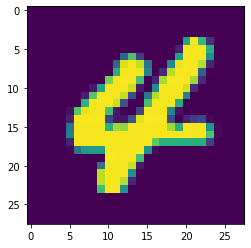

Generating interpolations...


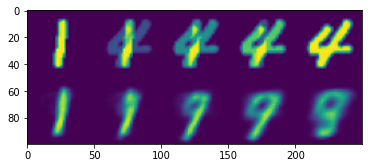

In [66]:
import os
import sys
import h5py
import cv2
import math
import random, string

from scipy.stats import norm
from sklearn import manifold
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

modelsPath = "Models/"
visualsPath = "Visuals/"

imageSize = 28
latent_dim = 32

# Show every image, good for picking interplation candidates
def visualizeDataset(X):
    for i,image in enumerate(X):
        cv2.imshow(str(i),image)
        cv2.waitKey()
        cv2.destroyAllWindows()

# Scatter with images instead of points
def imscatter(x, y, ax, imageData, zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        # Convert to image
        img = imageData[i]*255.
        img = img.astype(np.uint8).reshape([imageSize,imageSize])
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        # Note: OpenCV uses BGR and plt uses RGB
        image = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()



# Reconstructions for samples in dataset TODOOOOOO
def getReconstructedImages(X, autoencoder):
    nbSamples = X.shape[0]
    nbSquares = int(math.sqrt(nbSamples))
    nbSquaresHeight = 2*nbSquares
    nbSquaresWidth = nbSquaresHeight
    print("nbSamples", nbSamples)
    print("nbSquares", nbSquares)
    print("nbSquaresHeight", nbSquaresHeight)
    print("nbSquaresWidth", nbSquaresWidth)

    resultImage = np.zeros((nbSquaresHeight*imageSize,nbSquaresWidth*imageSize//2,X.shape[-1]))
    print(resultImage.shape)
    
    reconstructedX = autoencoder.predict(X)
    print("pREDICTIONS",reconstructedX.shape )
    for i in range(nbSamples):
        original = X[i]
        reconstruction = reconstructedX[i]
        rowIndex = i%nbSquaresWidth
        columnIndex = (i-rowIndex)//nbSquaresHeight
        print(rowIndex ,columnIndex)
        #print(rowIndex*imageSize,(rowIndex+1)*imageSize,columnIndex*2*imageSize,(columnIndex+1)*2*imageSize)
        resultImage[rowIndex*imageSize:(rowIndex+1)*imageSize,columnIndex*2*imageSize:(columnIndex+1)*2*imageSize,:] = np.hstack([original,reconstruction])

    return resultImage

# Reconstructions for samples in dataset TODOOOOOOO
def visualizeReconstructedImages(X_train, X_test, autoencoder, save=False, label=False):
    trainReconstruction = getReconstructedImages(X_train,autoencoder)
    testReconstruction = getReconstructedImages(X_test,autoencoder)

    if not save:
        print("Generating 10 image reconstructions...")

    result = np.hstack([trainReconstruction,np.zeros([trainReconstruction.shape[0],5,trainReconstruction.shape[-1]]),testReconstruction])
    result = (result*255.).astype(np.uint8)

    if save:
        cv2.imwrite(visualsPath+"reconstructions_{}.png".format(label),result)
    else:
        cv2.imshow("Reconstructed images (train - test)",result)
        cv2.waitKey()
        cv2.destroyAllWindows()



# Shows linear inteprolation in image space vs latent space
def visualizeInterpolation(start, end, encoder, decoder, save=False, nbSteps=5):
    print("Generating interpolations...")

    # Create micro batch
    X = np.array([start,end])

    # Compute latent space projection
    latentX = encoder.predict(X)
    latentStart, latentEnd = latentX

    # Get original image for comparison
    startImage, endImage = X

    vectors = []
    normalImages = []
    #Linear interpolation
    alphaValues = np.linspace(0, 1, nbSteps)
    for alpha in alphaValues:
        # Latent space interpolation
        vector = latentStart*(1-alpha) + latentEnd*alpha
        vectors.append(vector)
        # Image space interpolation
        blendImage = cv2.addWeighted(startImage,1-alpha,endImage,alpha,0)
        normalImages.append(blendImage)

    # Decode latent space vectors
    vectors = np.array(vectors)
    reconstructions = decoder.predict(vectors)

    # Put final image together
    resultLatent = None
    resultImage = None

    if save:
        hashName = ''.join(random.choice(string.lowercase) for i in range(3))

    for i in range(len(reconstructions)):
        interpolatedImage = normalImages[i]*255
        interpolatedImage = cv2.resize(interpolatedImage,(50,50))
        interpolatedImage = interpolatedImage.astype(np.uint8)
        resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage,interpolatedImage])

        reconstructedImage = reconstructions[i]*255.
        reconstructedImage = reconstructedImage.reshape([28,28])
        reconstructedImage = cv2.resize(reconstructedImage,(50,50))
        reconstructedImage = reconstructedImage.astype(np.uint8)
        resultLatent = reconstructedImage if resultLatent is None else np.hstack([resultLatent,reconstructedImage])
    
        if save:
            cv2.imwrite(visualsPath+"{}_{}.png".format(hashName,i),np.hstack([interpolatedImage,reconstructedImage]))

        result = np.vstack([resultImage,resultLatent])

    if not save:
        plt.imshow(result)

        

X = X_valid[:10]
print(X.shape)

#getReconstructedImages(X, vae)
start = X_valid[0]
plt.imshow(np.squeeze(start))
plt.show()
end = X_valid[100]
plt.imshow(np.squeeze(end))
plt.show()
visualizeInterpolation(start, end, encoder, decoder, save=False, nbSteps=5)



